In [1]:
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, TensorDataset, DataLoader

from pytorchtools import EarlyStopping

import pandas as pd
import numpy as np
import cv2
import os

from matplotlib import pyplot as plt
from sklearn.metrics import balanced_accuracy_score

In [2]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
def Network():
    network = nn.Sequential(

        Flatten(),
        nn.Linear(1*28*28,200),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(200,100),
        nn.ReLU(),
        nn.Linear(100, 2)
        

    )
    return network


In [3]:
def data_train(path_benign, filenames_benign, path_adversarial, filenames_adversarial):
    my_x = []
    my_y_np = np.array([])
    
    for filename in filenames_benign:
        my_x.append(cv2.imread(os.path.join(path_benign, filename), 0))
        my_y_np= np.append(my_y_np, np.array(0).astype(np.uint8))
        
    for filename in filenames_adversarial:
        my_x.append(cv2.imread(os.path.join(path_adversarial, filename), 0))
        my_y_np= np.append(my_y_np, np.array(1).astype(np.uint8))
        
    my_y = torch.from_numpy(my_y_np).float()
    
    tensor_x = torch.Tensor(my_x)
    tensor_x = tensor_x.unsqueeze(1)
    tensor_y = torch.Tensor(my_y)

    dataset = TensorDataset(tensor_x,tensor_y)
    
    return dataset

In [4]:
def data_test(path, filenames):
    my_x = []    
    my_y_np = np.array([])
    
    
    for filename in filenames:
        
        my_x.append(cv2.imread(os.path.join(path, filename), 0))
        my_y_np= np.append(my_y_np, np.array(-1).astype(np.uint8))
        
    my_y = torch.from_numpy(my_y_np).float()
    
    tensor_x = torch.Tensor(my_x)
    tensor_x = tensor_x.unsqueeze(1)
    tensor_y = torch.Tensor(my_y)
    
    dataset = TensorDataset(tensor_x,tensor_y)
    return dataset

In [5]:
def train(network, epochs, dataloader_train, dataloader_val, opt, scheduler, early_stopping):
    
    all_train_losses = []
    all_valid_losses = []
    
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss = 0
        train_acc = 0
        train_n = 0
        
        val_loss = 0
        val_acc = 0
        val_n = 0
        
        network.train()
        for i, (X,y) in enumerate(dataloader_train):
            X, y = X.cuda(), y.cuda()
            output = network(X)
            loss = criterion(output, y.long())
            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item() * y.size(0)
            train_acc += (output.max(1)[1] == y).sum().item()
            train_n += y.size(0)
        
        train_loss = train_loss / train_n
        all_train_losses.append(train_loss)

        network.eval()
        for i, (X,y) in enumerate(dataloader_val):
            X, y = X.cuda(), y.cuda()        
            output = network(X)
            loss = criterion(output, y.long())
            val_loss += loss.item() * y.size(0)
            val_acc += (output.max(1)[1] == y).sum().item()
            val_n += y.size(0)
            
        val_loss = val_loss/val_n
        all_valid_losses.append(val_loss)

        early_stopping(val_loss, network)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        scheduler.step()
        
        print('epoch:{}, \t lr:{}, \n train loss:{}, \t val loss:{}, \n train acc:{}, \t\t\t val acc:{} \n\n'.format(epoch, scheduler.get_last_lr() , train_loss, val_loss, train_acc/train_n, val_acc/val_n))
    
        
        
    # load the last checkpoint with the best model
    network.load_state_dict(torch.load('checkpoint.pt'))

    return  network, all_train_losses, all_valid_losses

In [6]:
def evaluate(network, dataloader):
    
    network.eval()
    
    total_loss = 0
    total_acc = 0
    n = 0
    
    criterion = nn.CrossEntropyLoss()
    
    for i, (X,y) in enumerate(dataloader):
        X, y = X.cuda(), y.cuda()
        output = network(X)
        loss = F.cross_entropy(output, y.long())
        
        total_loss += loss.item() * y.size(0)
        total_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)

    print('Validation Loss: {}, Acc:{}'.format(total_loss/n, total_acc/n))

In [7]:
def predict(network, dataloader):
    
    network.eval()
    
    n = 0
    preds = []
    
    for i, (X,y) in enumerate(dataloader):
        X = X.cuda()
        output = network(X)
        preds.append(output.max(1)[1].item())

    return preds

# Read data

In [8]:
path_train_benign = os.path.join(os.getcwd(), "ch01-train")
filenames_train_benign = os.listdir(path_train_benign)

path_train_adversarial = os.path.join(os.getcwd(), "ch02-train")
filenames_train_adversarial = os.listdir(path_train_adversarial)

path_test = os.path.join(os.getcwd(), "ch02-test")
filenames_test = os.listdir(path_test)

In [9]:
dataset_train = data_train(path_train_benign, filenames_train_benign, path_train_adversarial, filenames_train_adversarial)

In [10]:
dataset_test = data_test(path_test, filenames_test)

In [11]:
train_set, val_set = torch.utils.data.random_split(dataset_train, [90000, 30000])

dataloader_train = DataLoader(train_set, batch_size = 128) 
dataloader_val = DataLoader(val_set, batch_size = 128) 
dataloader_test = DataLoader(dataset_test, batch_size = 1) 

# Train network

In [12]:
network = Network().cuda()
network.train()
epochs = 60
    
opt = torch.optim.Adam(network.parameters(), lr=0.001)
scheduler = StepLR(opt, step_size=5, gamma=0.3)
early_stopping = EarlyStopping(patience=15, verbose=True)
    
network, all_train_losses, all_valid_losses = train(network, epochs, dataloader_train, dataloader_val, opt, scheduler, early_stopping)

Validation loss decreased (inf --> 0.000334).  Saving model ...
epoch:0, 	 lr:[0.001], 
 train loss:0.053914685113126165, 	 val loss:0.000334029789015464, 
 train acc:0.9939333333333333, 			 val acc:0.9998666666666667 


EarlyStopping counter: 1 out of 15
epoch:1, 	 lr:[0.001], 
 train loss:0.0041323196741067355, 	 val loss:0.0007572481258294793, 
 train acc:0.9990666666666667, 			 val acc:0.9998666666666667 


EarlyStopping counter: 2 out of 15
epoch:2, 	 lr:[0.001], 
 train loss:0.0029211949497533612, 	 val loss:0.0003659711971784454, 
 train acc:0.9992555555555556, 			 val acc:0.9998333333333334 


EarlyStopping counter: 3 out of 15
epoch:3, 	 lr:[0.001], 
 train loss:0.00410968271333927, 	 val loss:0.009662537289286713, 
 train acc:0.9991, 			 val acc:0.9982333333333333 


EarlyStopping counter: 4 out of 15
epoch:4, 	 lr:[0.0003], 
 train loss:0.003597994220736147, 	 val loss:0.0006165224255349467, 
 train acc:0.9993111111111111, 			 val acc:0.9998 


Validation loss decreased (0.0

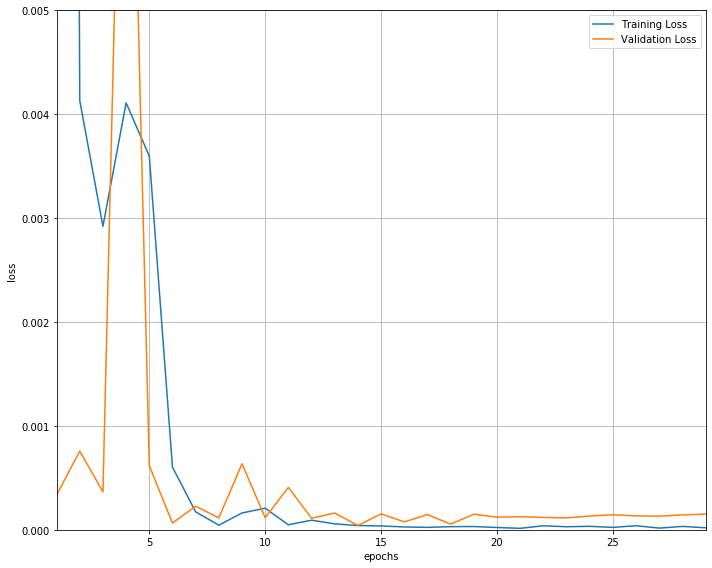

In [13]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(all_train_losses)+1),all_train_losses, label='Training Loss')
plt.plot(range(1,len(all_valid_losses)+1),all_valid_losses,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.005) # consistent scale
plt.xlim(1, len(all_train_losses)) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Predict test data

In [14]:
preds = predict(network, dataloader_test)

In [15]:
pd.Series(preds, index = filenames_test).to_csv("predictions_1.csv", header = None)

c:\users\m\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
